In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', grid=True)  # Personal preference

In [2]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s |data %.4f |grad %.4f }" % (
            n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

#### Important Math Ideas to Keep in Mind
##### The Definition of the Derivative
Intuition pumps: linear approximation, local slope, normalized effect of nudging or wiggling, fix/set in stone other variables when nudging one,
$$
\frac{\mathrm{d}}{\mathrm{d}x} f(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h}
$$
##### The Chain Rule
$$
\frac{df}{dx} = \frac{df}{du} \frac{du}{dx}
$$
##### tanh
$$
\tanh x = \frac{\sinh x}{\cosh x} = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{e^{2x}-1}{e^{2x}+1}, \quad \frac{d}{dx} \tanh x = 1 - \tanh^2 x
$$


#### Value Object

In [103]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # w/o this we would error on say a + 1 bc 1.data would not exist
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # when we call this we are working backwards so we know out.grad will already be set
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        # only int or float powers for now for some reason not value
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):  # self*other not other*self. Ex: 2*a python tries 2.mul(a), then tries a.rmul(2) so self is first here
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        out = Value(np.tanh(self.data), (self,), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        for node in reversed(topo):
            node.grad = 0

        self.grad = 1  # call backward on the output node

        for node in reversed(topo):
            node._backward()

In [41]:
a = Value(2)
b = Value(4)
a - b

Value(data=-2)

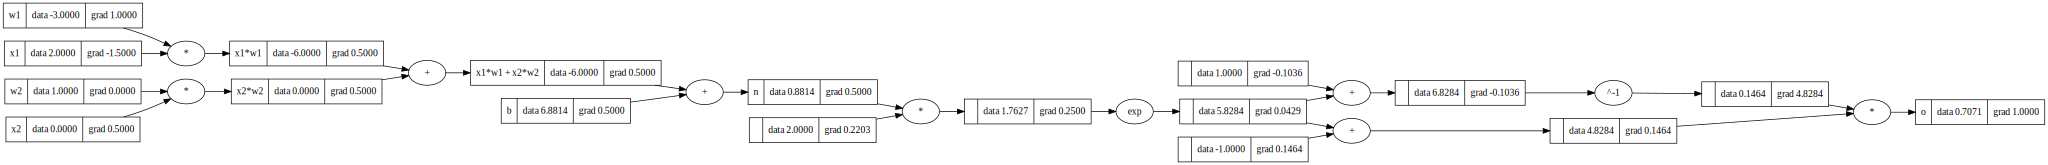

In [42]:
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
# weights
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# weighted inputs
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
# raw activation
n = x1w1x2w2 + b
n.label = 'n'
# output
# o = n.tanh()
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

### PyTorch

In [3]:
import torch

x1 = torch.tensor([2], requires_grad=True, dtype=torch.float64)
x2 = torch.tensor([0], requires_grad=True, dtype=torch.float64)
w1 = torch.tensor([-3], requires_grad=True, dtype=torch.float64)
w2 = torch.tensor([1], requires_grad=True, dtype=torch.float64)
b = torch.tensor([6.8813735870195432], requires_grad=True, dtype=torch.float64)

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1.grad', x1.grad.item())
print('x2.grad', x2.grad.item())
print('w1.grad', w1.grad.item())
print('w2.grad', w2.grad.item())

0.7071067811865476
---
x1.grad -1.4999999999999998
x2.grad 0.49999999999999994
w1.grad 0.9999999999999999
w2.grad 0.0


In [4]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [47]:
torch.tensor([[1., 2., 3.], [4., 5., 6.]]).dtype

torch.float32

### Building out a Neural Network

<center>
  <img src="neuron.png" style="width: 40%; margin-right: 5%;">
  <img src="mlp.png" style="width: 40%;">
</center>

In [66]:
class Neuron:
    def __init__(self, num_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_in)]
        self.b = Value(random.uniform(-1, 1))

    # do the forward pass when calling
    def __call__(self, x):
        # return w*x + b
        activation = sum((wi*xi for wi, xi in zip(self.w, x)),
                         self.b)  # w*x + b
        out = activation.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]  # concatenated

# each layer is a list of neurons NOT connected to each other but YES connected to all inputs (of the previous layer)


class Layer:
    def __init__(self, num_in, num_out):
        self.neurons = [Neuron(num_in) for _ in range(num_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neurons.parameters()
        #     params.extend(ps)
        # return params


class MLP:
    def __init__(self, num_in, num_outs):
        ins = [num_in, *num_outs[:-1]]
        self.layers = [Layer(n_in, n_out)
                       for n_in, n_out in zip(ins, num_outs)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [67]:
x = [2, 3, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.4438718658803834)

In [6]:
len(n.parameters())

41

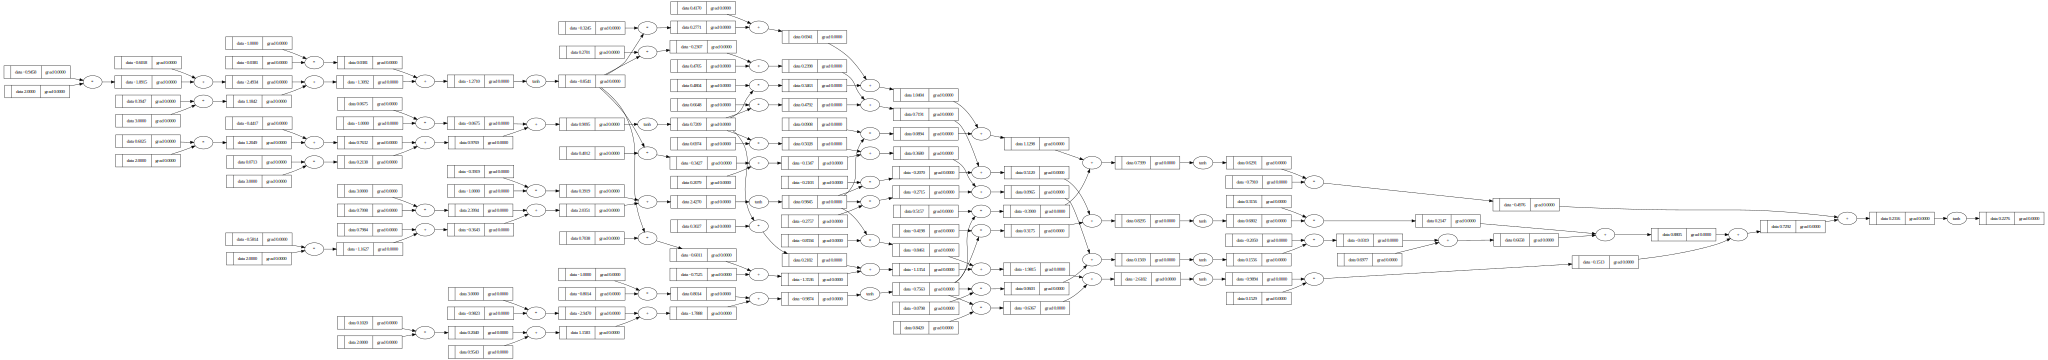

In [7]:
draw_dot(n(x))

In [110]:
# binary classifier
xs = [  # inputs
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]
ys = [1, -1, -1, -1]  # desired targets


In [111]:
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.962196320241595)

In [112]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ytruth)**2 for ytruth, yout in zip(ys, ypred))

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)    

0 3.85596758376283
1 3.7858160810802106
2 3.622698152888864
3 3.1280888871157995
4 2.5177845653266324
5 3.232829099383732
6 1.4051056136704658
7 0.8578502176718665
8 2.104083784491301
9 6.695323457403957
10 0.9406132387004891
11 0.7569232367554737
12 2.18434090702257
13 5.126825853401839
14 2.017045686091993
15 0.28848569967850013
16 0.16840805951905927
17 0.0784921696348527
18 0.059076491084919976
19 0.04936160963917272


In [85]:
mean_sq_errs = [(yout-ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = sum(mean_sq_errs)
print(loss)

Value(data=3.0787313776039857)


In [82]:
loss.backward()

In [83]:
for p in n.parameters():
    p.data += -0.1 * p.grad

In [53]:
n.layers[0].neurons[0].w[0].grad

-0.13449649268856012

In [59]:
n.layers[0].neurons[0].w[0].data

-0.2667240522882335

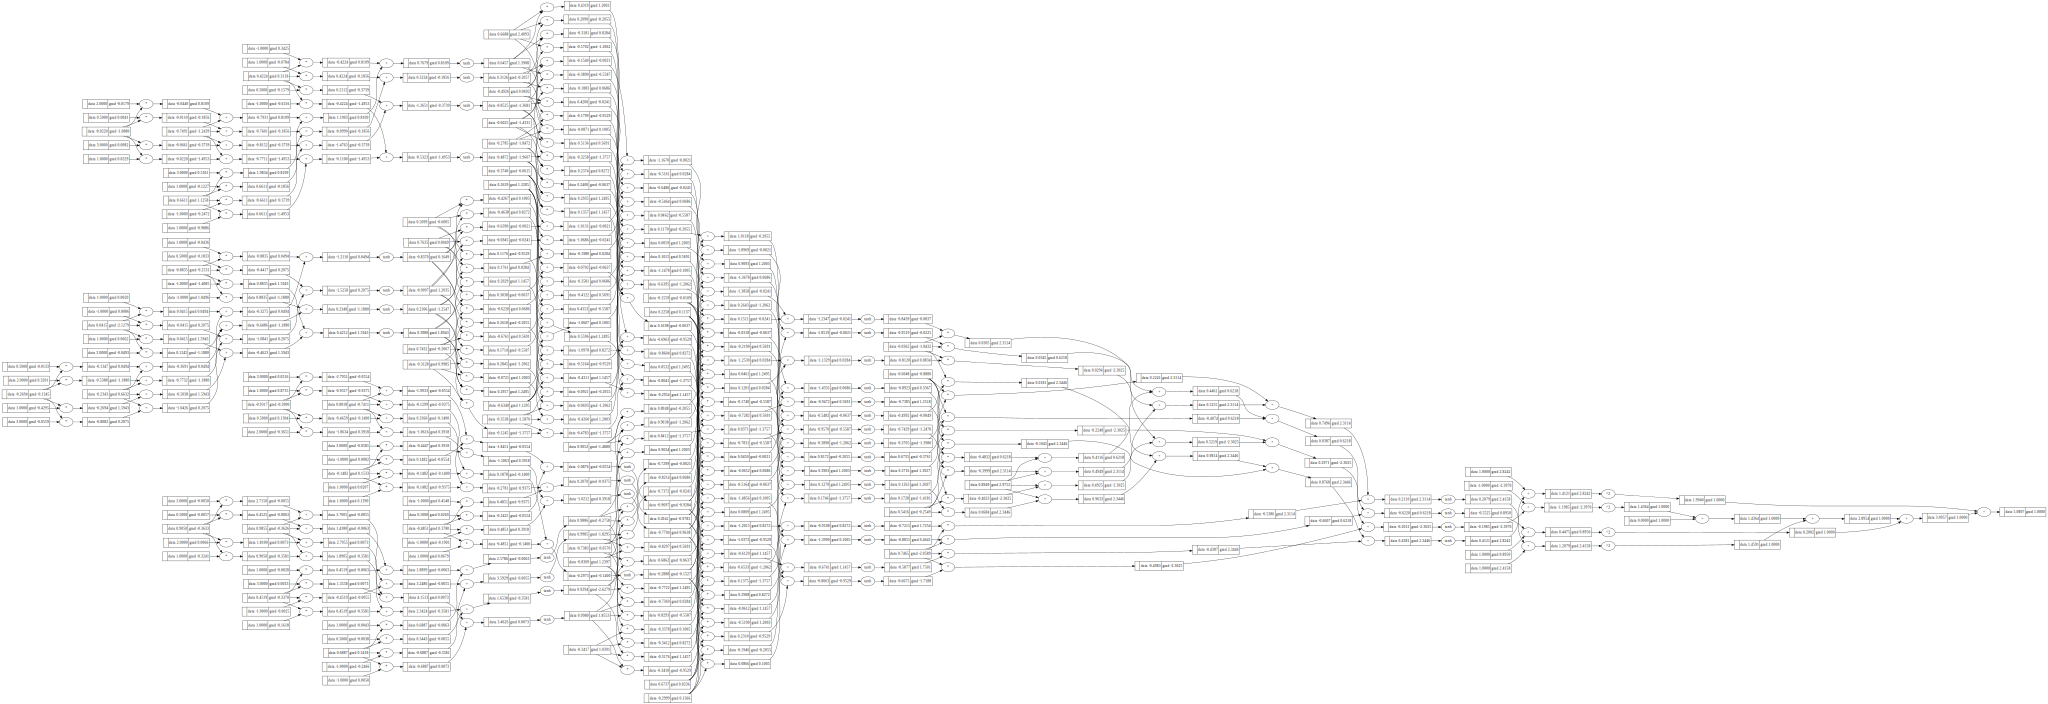

In [54]:
draw_dot(loss)

### Earlier Work, Deleted in the Video

In [5]:
a = Value(2, label='a')
b = Value(-3, label='b')
c = Value(10, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2, label='f')
L = d*f
L.label = 'L'

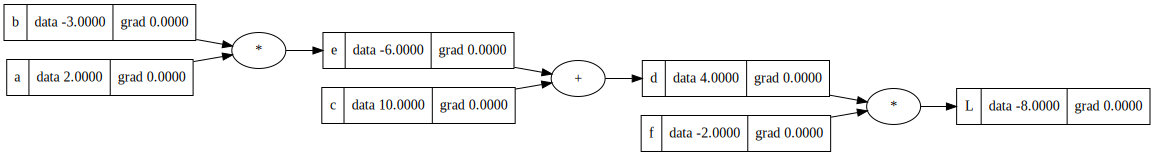

In [6]:
draw_dot(L)

In [10]:
def manual_testing():
    h = 1e-9

    a = Value(2, label='a')
    b = Value(-3, label='b')
    c = Value(10, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2, label='f')
    L = d*f
    L.label = 'L'
    L1 = L.data

    a = Value(2, label='a')
    b = Value(-3+h, label='b')
    c = Value(10, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2, label='f')
    L = d*f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)


manual_testing()
# Manual backprop
L.grad = 1
f.grad = d.data  # 4
d.grad = f.data  # -2
c.grad = 1 * d.grad  # -2
e.grad = 1 * d.grad  # -2
a.grad = b.data * e.grad  # -6
b.grad = a.data * e.grad  # -4

-4.000000330961484


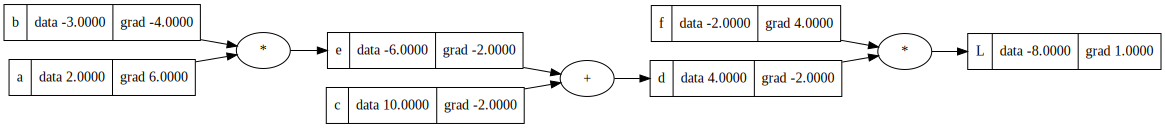

In [11]:
draw_dot(L)

-7.286496


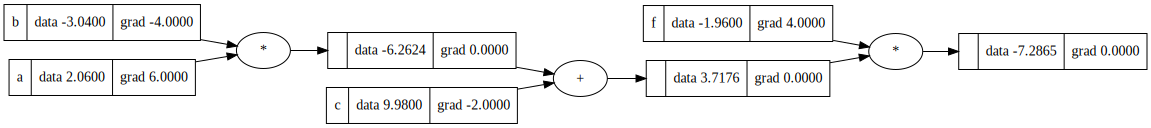

In [12]:
# backprop
step_size = 0.01
a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad
# forward pass
e = a*b
d = e + c
L = d*f
print(L.data)
draw_dot(L)

#### Neural Network

<center><img src="neuron.png"/></center>

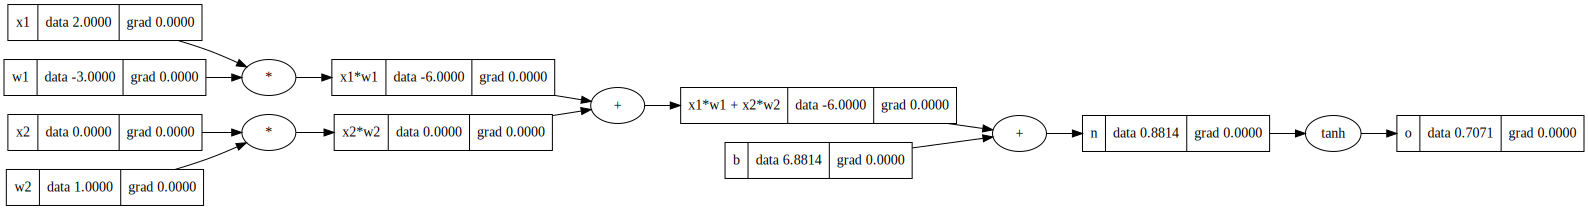

In [20]:
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')
# weights
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# weighted inputs
x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'
# raw activation
n = x1w1x2w2 + b
n.label = 'n'
# output
o = n.tanh()
o.label = 'o'
draw_dot(o)

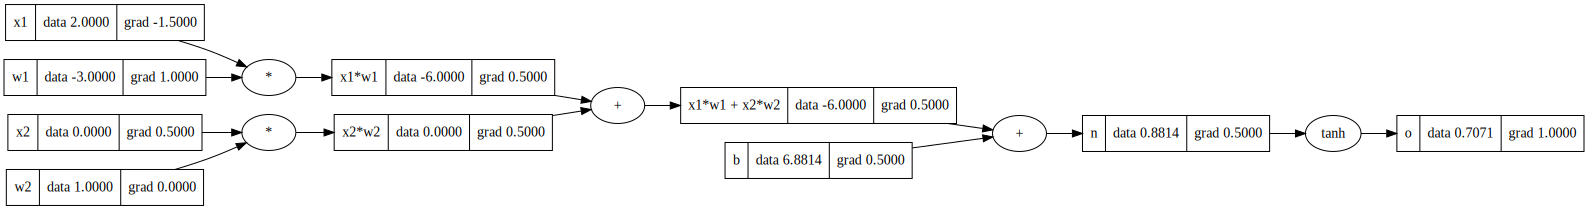

In [21]:
# automatic backprop
o.backward()
draw_dot(o)

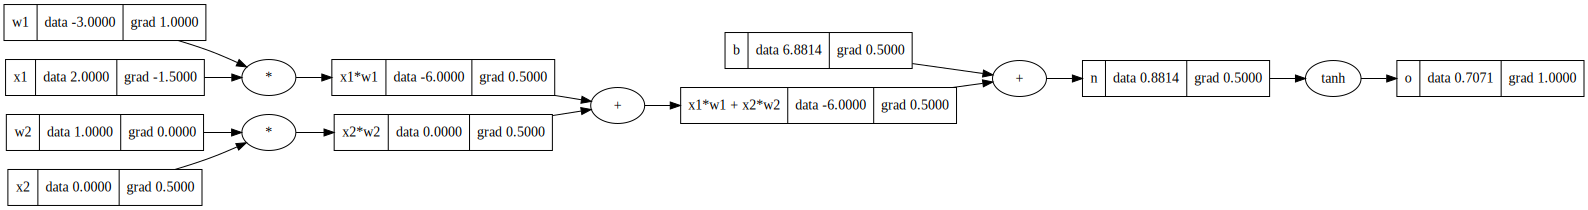

In [18]:
# semi-automatic backprop
o.grad = 1  # base case

topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

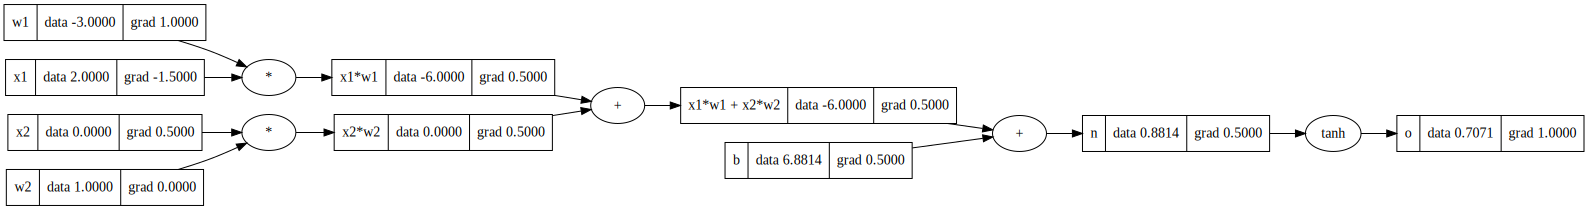

In [9]:
# semi-manual backprop
o.grad = 1  # else o.grad = 0 and anything multiplied by zero is zero
o._backward()
n._backward()
b._backward()  # leaf node so nothing happens...
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

draw_dot(o)

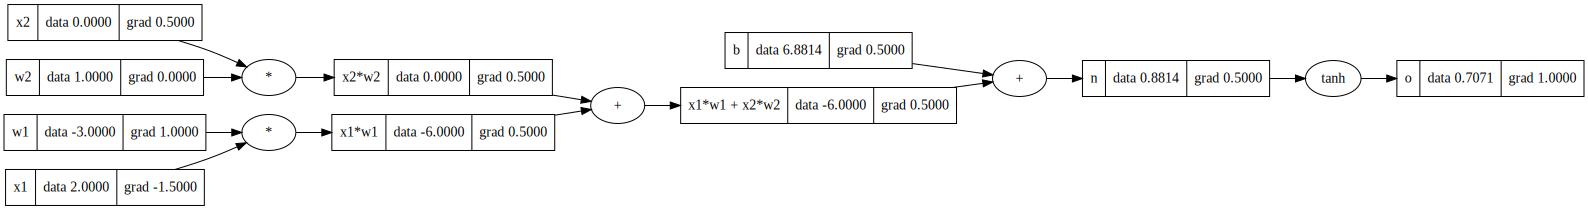

In [8]:
# manual backprop
o.grad = 1
n.grad = o.grad * (1 - o.data**2)  # 0.5, derivative of tanh is 1 - tanh^2
x1w1x2w2.grad = n.grad  # d/dx of x + y is 1
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad  # still a plus node
x2w2.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad  # times node
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
draw_dot(o)

#### Post-Implementing Backprop

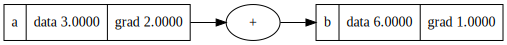

In [ ]:
a = Value(3, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)

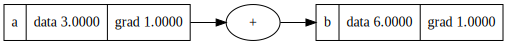

In [6]:
a = Value(3, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dot(b)
# bad because we don't consider the same variable showing up more than once

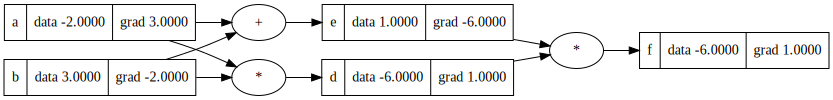

In [ ]:
# not as direct as a+a but still has the problem since the gradient depends on a and b through multiple paths
a = Value(-2, label='a')
b = Value(3, label='b')
d = a*b
d.label = 'd'
e = a+b
e.label = 'e'
f = d*e
f.label = 'f'
f.backward()
draw_dot(f)

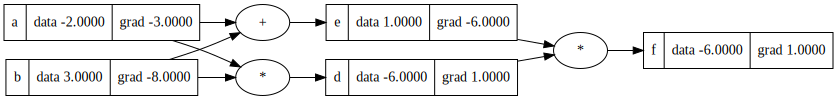

In [9]:
a = Value(-2, label='a')
b = Value(3, label='b')
d = a*b
d.label = 'd'
e = a+b
e.label = 'e'
f = d*e
f.label = 'f'
f.backward()
draw_dot(f)

#### Scratchpad

In [61]:
def f(x):
    return 3*x**2 - 4*x + 5


def derivative_demo(f, x, h=1e-9):
    print(f"f(x = {x}) = {f(x)}")
    print(f"f(x+h = {x + h}) = {f(x + h)}")
    dfdx = (f(x + h) - f(x)) / h
    print(f"(f(x+h)-f(x))/h = ({f(x + h)} - {f(x)}) / {h} = {dfdx}\n")
    plt.plot(x, f(x), 'ro')
    xs = np.arange(x - 2, x + 2, 0.01)
    plt.plot(xs, dfdx * (xs - x) + f(x), color='red', linestyle='--')
    return (f(x + h) - f(x)) / h

f(x = 3) = 20
f(x+h = 3.000000001) = 20.000000014
(f(x+h)-f(x))/h = (20.000000014 - 20) / 1e-09 = 14.000001158365194

f(x = -3) = 44
f(x+h = -2.999999999) = 43.999999978
(f(x+h)-f(x))/h = (43.999999978 - 44) / 1e-09 = -22.000001820288162

f(x = 0.6666666666666666) = 3.666666666666667
f(x+h = 0.6666666676666666) = 3.666666666666667
(f(x+h)-f(x))/h = (3.666666666666667 - 3.666666666666667) / 1e-09 = 0.0



0.0

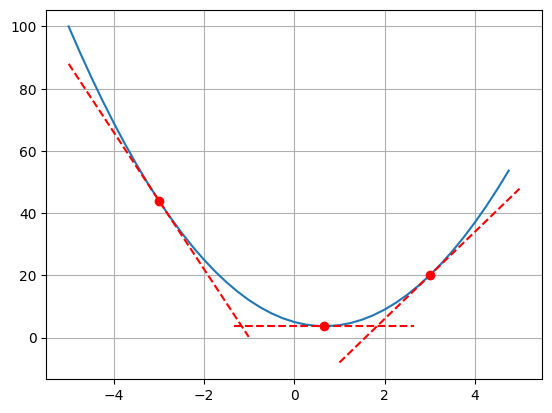

In [62]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
derivative_demo(f, 3)
derivative_demo(f, -3)
derivative_demo(f, 2/3)

In [66]:
a = 2
b = -3
c = 10

d1 = a*b + c
print(d1)
h = 0.0000001
c += h
d2 = a*b + c
print(d2)
print("slope =", (d2 - d1) / h)

4
4.000000099999999
slope = 0.999999993922529


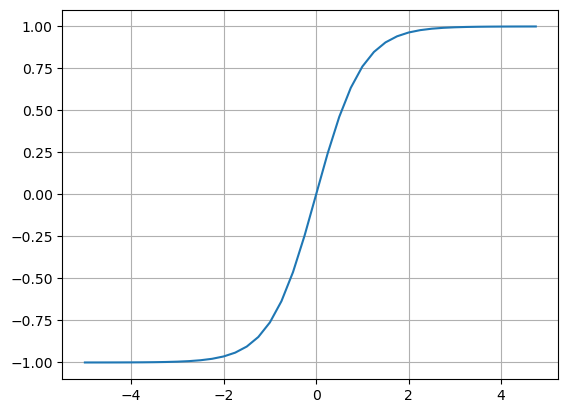

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(xs)
plt.plot(xs, ys)